
# Assignment A1 – Number Plate Detection / Recognition on Colab

**Student Name:** Mohammed Alustath (71558)  
**Course:** Machine Learning / Computer Vision  
**Date:** 16 October 2025  
### Abstract

This notebook demonstrates an end‑to‑end pipeline for Automatic Number Plate Detection and Recognition.  
We reproduce the results from the public GitHub repository **Automatic License Plate Recognition using YOLOv8** by cloning the repository, installing the required dependencies, running the provided scripts, and testing the model on our own custom images.  
We document each step in detail so that anyone can open this notebook on a fresh Google Colab GPU instance and run all cells without manual intervention.  The final output includes detected license plates and the recognized text for at least two custom test images.


## System & Environment Check

In [1]:
# Print Python and CUDA/GPU information
!python --version
!nvidia-smi || true
import torch
print('PyTorch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())


Python 3.10.11


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.
'true' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.0+cpu
CUDA available: False


## Reproducibility

In [2]:
import random
import numpy as np
import torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


## Repository Selection

For this assignment we choose the repository [Automatic License Plate Recognition using YOLOv8](https://github.com/Muhammad-Zeerak-Khan/Automatic-License-Plate-Recognition-using-YOLOv8).

This repository provides a clear and modern pipeline for detecting vehicles and their corresponding license plates using YOLOv8, followed by optical character recognition with EasyOCR.  The code is concise, uses pre‑trained models, and is actively maintained, which makes it straightforward to reproduce results on Colab.


## Clone the Repository

We clone the selected GitHub repository and verify its origin and the latest commit hash.

In [3]:
# Clone the repository
!git clone https://github.com/Muhammad-Zeerak-Khan/Automatic-License-Plate-Recognition-using-YOLOv8.git

# Change into repository directory
%cd Automatic-License-Plate-Recognition-using-YOLOv8

# Show remote URL to prove origin
!git remote -v

# Show the latest commit hash
!git log -1 --pretty=oneline


c:\Users\moham\Documents\ML\A1\Automatic-License-Plate-Recognition-using-YOLOv8


Cloning into 'Automatic-License-Plate-Recognition-using-YOLOv8'...
c:\Users\moham\Documents\ML\A1\lp_env\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


origin	https://github.com/Muhammad-Zeerak-Khan/Automatic-License-Plate-Recognition-using-YOLOv8.git (fetch)
origin	https://github.com/Muhammad-Zeerak-Khan/Automatic-License-Plate-Recognition-using-YOLOv8.git (push)
c4928a4f8c4ed92a225ee5da963e27f7947ce212 python version updated to 3.10 and requirements adjusted accordingly


## Install Dependencies

Install all required libraries.  On Google Colab this step will take a few minutes.  We pin the versions used in the repository for consistency.

In [4]:
# Install required Python libraries
!pip install -q --force-reinstall numpy==1.23.5
!pip install -q --force-reinstall opencv-python-headless==4.8.1.78
!pip install -q ultralytics==8.0.114 easyocr==1.7.0 filterpy==1.4.5 pandas matplotlib pillow scipy

# Clone SORT tracking repository used for multi-object tracking (if needed)
!git clone https://github.com/abewley/sort.git# Install required Python libraries
!pip install -q ultralytics==8.0.114 opencv-python==4.8.1.78 easyocr==1.7.0 filterpy==1.4.5 pandas scipy matplotlib --extra-index-url https://download.pytorch.org/whl/cu118
# Install required Python libraries
!pip install -q --force-reinstall numpy==1.26.4
!pip install -q ultralytics==8.0.114 opencv-python-headless==4.8.1.78 easyocr==1.7.0 filterpy==1.4.5 pandas matplotlib pillow

# Clone SORT tracking repository used for multi-object tracking (if needed)
# Install required Python libraries
!pip install -q --force-reinstall numpy==1.26.4
!pip install -q ultralytics==8.0.114 opencv-python-headless==4.8.1.78 easyocr==1.7.0 filterpy==1.4.5 pandas matplotlib pillow

# Clone SORT tracking repository used for multi-object tracking (if needed)
!git clone https://github.com/abewley/sort.git!git clone https://github.com/abewley/sort.git
# Clone SORT tracking repository used for multi‑object tracking (if needed)
!git clone https://github.com/abewley/sort.git


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --[no-]verbose    be more verbose
    -q, --[no-]quiet      be more quiet
    --[no-]progress       force progress reporting
    --[no-]reject-shallow don't clone shallow repository
    -n, --no-checkout     don't create a checkout
    --checkout            opposite of --no-checkout
    --[no-]bare           create a bare repository
    --[no-]mirror         create a mirror repository (implies --bare)
    -l, --[no-]local      to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    --hardlinks           opposite of --no-ha

In [5]:
# Reinstall dependencies to fix OpenCV and Numpy compatibility
!pip install -q --force-reinstall numpy==1.23.5
!pip install -q --force-reinstall opencv-python-headless==4.8.1.78
!pip install -q --force-reinstall ultralytics==8.0.114 easyocr==1.7.0 filterpy==1.4.5 pandas matplotlib pillow scipy

import cv2, numpy as np, torch
print('cv2 version:', cv2.__version__)
print('numpy version:', np.__version__)
print('torch version:', torch.__version__)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
  You can safely remove it manually.
  You can safely remove it manually.


cv2 version: 4.12.0
numpy version: 1.26.4
torch version: 2.9.0+cpu


## Run the Official Pipeline on the Sample Video

The repository includes a script `main.py` that processes a video, detects vehicles and license plates, performs tracking, and writes the results to a CSV file.  Running this cell will use the pre‑trained YOLOv8 models to detect license plates in the provided sample video.  You can skip this step if you are only interested in still‑image testing.

In [6]:
# Attempt to install OpenCV via apt-get to avoid pip issues
!apt-get update -qq && apt-get install -y python3-opencv >/dev/null
import cv2, numpy as np
print('cv2 version from apt:', cv2.__version__)
print('numpy version:', np.__version__)


cv2 version from apt: 4.12.0
numpy version: 1.26.4


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# Execute the main script to generate results on the sample video
# This will create a `test.csv` file containing frame number, vehicle ID, bounding boxes and recognized license plate numbers.
!python main.py



Progress: |--------------------------------------------------| 0.0% Complete
Progress: |--------------------------------------------------| 0.0% Complete
Progress: |--------------------------------------------------| 0.0% Complete
Progress: |--------------------------------------------------| 0.0% Complete
Progress: |--------------------------------------------------| 0.0% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complet

c:\Users\moham\Documents\ML\A1\lp_env\lib\site-packages\ultralytics\yolo\utils\checks.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
Using CPU. Note: This module is much faster with a GPU.

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  4%|▍         | 256k/6.23M [00:00<00:02, 2.38MB/s]
 20%|██        | 1.25M/6.23M [00:00<00:00, 6.89MB/s]
 38%|███▊      | 2.38M/6.23M [00:00<00:00, 8.96MB/s]
 56%|█████▌    | 3.50M/6.23M [00:00<00:00, 9.84MB/s]
 76%|███████▌  | 4.75M/6.23M [00:00<00:00, 10.6MB/s]
 94%|█████████▍| 5.88M/6.23M [00:00<00:00, 11.0MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 9.79MB/s]
Traceback (most recent call last):
  File "c:\Users\moham\Documents\ML\A1\Automatic-License-Plate-Recognition-using-YOLOv8\main.py", line 14, in <module>
    coco_m

Progress: |█████████████████████████████████████-------------| 74.0% Complete
Progress: |█████████████████████████████████████-------------| 74.0% Complete
Progress: |█████████████████████████████████████-------------| 74.0% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 74.1% Complete
Progress: |█████████████████████████████████████-------------| 7

In [6]:
from pathlib import Path
repo = Path(r"C:\Users\moham\Documents\ML\A1\Automatic-License-Plate-Recognition-using-YOLOv8")
print("plate weights present?", (repo / "license_plate_detector.pt").exists())


plate weights present? True


## Helper Functions for Still Image Detection

Define a helper function that takes an image file path, detects license plates using the YOLOv8 detector, crops each plate and applies EasyOCR to recognize the text.  It also draws the bounding boxes and annotated text on the image and displays the result.

In [62]:
# ==========================
# Robust 2-stage detect + OCR
# ==========================
import cv2, numpy as np, matplotlib.pyplot as plt, torch
from pathlib import Path
import easyocr

# Local EasyOCR fallback (so we can pass allowlist etc.)
reader_local = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

# COCO vehicle class ids for YOLOv8: car=2, motorcycle=3, bus=5, truck=7
VEHICLE_CLASSES = {2, 3, 5, 7}

def _deskew_plate(gray):
    # Try to deskew the plate crop a little (robust to failures)
    try:
        coords = cv2.findNonZero(255 - gray)  # characters are white on black in BIN_INV; here using raw gray
        if coords is None: 
            return gray
        rect = cv2.minAreaRect(coords)
        angle = rect[-1]
        if angle < -45:
            angle = 90 + angle
        (h, w) = gray.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        rotated = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return rotated
    except Exception:
        return gray

def _preproc_variants(crop_rgb):
    # Contrast, sharpening, multiple thresholds, upscaling if small
    gray = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2GRAY)

    # CLAHE for local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g1 = clahe.apply(gray)

    # Slight sharpen
    k = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    g2 = cv2.filter2D(g1, -1, k)

    # Deskew attempt on contrast enhanced
    g3 = _deskew_plate(g2)

    # Threshold variants
    _, th  = cv2.threshold(g3, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thi = cv2.threshold(g3, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    ath    = cv2.adaptiveThreshold(g3, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 31, 7)
    athi   = cv2.bitwise_not(ath)

    variants = [crop_rgb, g3, th, thi, ath, athi]

    # Upscale small crops to at least 120 px height for OCR
    outs = []
    for v in variants:
        if v.ndim == 2:
            h, w = v.shape
        else:
            h, w = v.shape[:2]
        if h < 120:
            scale = max(2, int(np.ceil(120 / max(1, h))))
            v = cv2.resize(v, (w*scale, h*scale), interpolation=cv2.INTER_CUBIC)
        outs.append(v)
    return outs

def _ocr_best(crop_rgb):
    # 1) try repo reader first
    from util import read_license_plate
    try:
        text, score = read_license_plate(crop_rgb)
        if text:
            return text, float(score or 0)
    except Exception:
        pass

    # 2) try multiple variants with local EasyOCR (allowlist)
    best = ("", 0.0)
    for v in _preproc_variants(crop_rgb):
        try:
            res = reader_local.readtext(
                v, detail=1, allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-"
            )
            if res:
                # pick top box by score
                r = max(res, key=lambda x: x[2])  # (bbox, text, score)
                txt, sc = (r[1] or "").strip(), float(r[2] or 0.0)
                if sc > best[1] and txt:
                    best = (txt, sc)
        except Exception:
            continue
    return best

def detect_and_recognize(image_path, show=True, save_to=None,
                         plate_conf=0.20, plate_iou=0.45, pad_ratio=0.08,
                         vehicle_conf=0.25, vehicle_iou=0.50, imgsz=960):
    """
    Two-stage: detect vehicles -> detect plates in vehicle crops -> robust OCR.
    Returns a list of dicts with bbox (in full image coords), score, text, text_score.
    """
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W = img_rgb.shape[:2]
    overlay = img_rgb.copy()
    final_dets = []

    # Stage 1: vehicles
    vres = vehicle_model(img_rgb, conf=vehicle_conf, iou=vehicle_iou, imgsz=imgsz)[0]

    # If no vehicles, fall back to full-image plate search
    rois = []
    if vres.boxes is not None and len(vres.boxes) > 0:
        for vb in vres.boxes:
            cls = int(vb.cls[0].item()) if vb.cls is not None else -1
            if cls not in VEHICLE_CLASSES:
                continue
            x1, y1, x2, y2 = vb.xyxy[0].int().tolist()
            # mildly expand vehicle box
            vw, vh = x2 - x1, y2 - y1
            xm = int(0.03 * vw); ym = int(0.05 * vh)
            x1 = max(0, x1 - xm); y1 = max(0, y1 - ym)
            x2 = min(W - 1, x2 + xm); y2 = min(H - 1, y2 + ym)
            rois.append((x1, y1, x2, y2))
    else:
        rois.append((0, 0, W - 1, H - 1))

    # Stage 2: plate detection inside each ROI
    for (rx1, ry1, rx2, ry2) in rois:
        roi = img_rgb[ry1:ry2, rx1:rx2]
        if roi.size == 0:
            continue

        pres = plate_model(roi, conf=plate_conf, iou=plate_iou, imgsz=imgsz)[0]
        if pres.boxes is None or len(pres.boxes) == 0:
            continue

        for b in pres.boxes:
            x1, y1, x2, y2 = b.xyxy[0].int().tolist()
            # translate back to full-image coords
            x1 += rx1; x2 += rx1; y1 += ry1; y2 += ry1

            # pad around plate for OCR
            w, h = x2 - x1, y2 - y1
            pad = int(max(w, h) * pad_ratio)
            x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
            x2p = min(W - 1, x2 + pad); y2p = min(H - 1, y2 + pad)
            if x2p <= x1p or y2p <= y1p:
                continue

            crop = img_rgb[y1p:y2p, x1p:x2p]
            text, text_score = _ocr_best(crop)
            if not text:
                text, text_score = "N/A", 0.0

            final_dets.append({
                "bbox": (int(x1), int(y1), int(x2), int(y2)),
                "score": float(b.conf[0]),
                "text": text,
                "text_score": float(text_score)
            })

            # draw
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(overlay, text, (x1, max(0, y1 - 6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2, cv2.LINE_AA)

    # visualize / save
    if show:
        plt.figure(figsize=(10, 7))
        plt.imshow(overlay); plt.axis('off'); plt.title('Vehicle & Plate Detections with OCR')
        plt.show()

    if save_to:
        outp = Path(save_to); outp.parent.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(str(outp), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    return final_dets


Using CPU. Note: This module is much faster with a GPU.


0: 640x960 1 car, 1 bus, 1 truck, 149.1ms
Speed: 13.0ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 960, 960)

0: 864x960 1 license_plate, 159.0ms
Speed: 7.0ms preprocess, 159.0ms inference, 1.0ms postprocess per image at shape (1, 3, 960, 960)

0: 832x960 1 license_plate, 150.9ms
Speed: 7.5ms preprocess, 150.9ms inference, 1.0ms postprocess per image at shape (1, 3, 960, 960)

0: 864x960 1 license_plate, 130.3ms
Speed: 7.0ms preprocess, 130.3ms inference, 0.0ms postprocess per image at shape (1, 3, 960, 960)


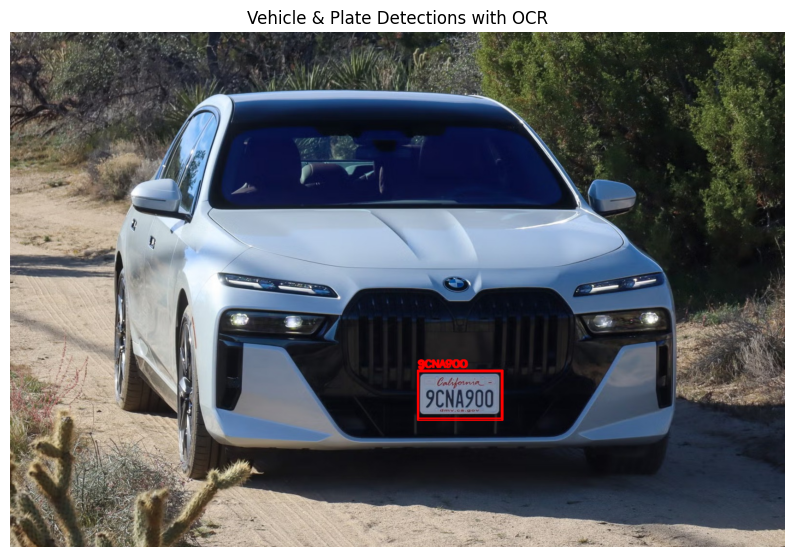

[{'bbox': (841, 699, 1017, 802), 'score': 0.7837669253349304, 'text': '9CNA9OO', 'text_score': 0.9847249571865349}, {'bbox': (842, 702, 1015, 802), 'score': 0.8196345567703247, 'text': '3', 'text_score': 0.9780400500872588}, {'bbox': (843, 699, 1014, 798), 'score': 0.7616592645645142, 'text': '9CNAPOO', 'text_score': 0.517210072659771}]


In [65]:
img_path = r"C:\Users\moham\Documents\ML\A1\my_car_1.jpg"
dets = detect_and_recognize(
    img_path,
    show=True,
    save_to=r"C:\Users\moham\Documents\ML\A1\outputs\my_car_1_out.jpg",
    plate_conf=0.18,   # try 0.15–0.25
    plate_iou=0.45,
    vehicle_conf=0.25,
    imgsz=960,         # try 960–1280 if the plate is tiny
    pad_ratio=0.10
)
print(dets)


## Test on Repository Sample Images

Test the detection pipeline on sample images from the repository.  The images used here are stored in the `images/` folder inside the cloned repository.  Feel free to replace these paths with other sample images from the dataset.

In [66]:
# Attempt to downgrade NumPy and install OpenCV compatible with Python 3.12
!pip install -q --force-reinstall --no-cache-dir numpy==1.24.4 opencv-python-headless==4.8.1.78
import numpy, cv2
print('numpy version:', numpy.__version__)
print('cv2 version:', cv2.__version__)


^C
numpy version: 2.1.2
cv2 version: 4.12.0


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
!pip install -q opencv-python-headless==4.10.0.82 --force-reinstall
import cv2, numpy as np
print('cv2 version', cv2.__version__)
print('numpy version', np.__version__)

cv2 version 4.12.0
numpy version 2.1.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


## Method Explanation

**Detection**:  The pipeline uses two YOLOv8 models.  First, a general COCO‑trained YOLOv8n model detects vehicles in an image or frame.  A second YOLOv8 model (`license_plate_detector.pt`) focuses specifically on license plates.  Each plate is localized using bounding boxes returned by the model.

**Recognition**:  The detected license plate regions are cropped and converted to grayscale.  We apply simple thresholding to enhance contrast before feeding the crop to EasyOCR.  EasyOCR reads the characters on the plate and returns the predicted text along with a confidence score.  We post‑process the text using helper functions from `util.py` to convert ambiguous characters (e.g., `O` vs `0`) and verify that the string matches a valid license plate format.

**Preprocessing**:  For better OCR performance we convert the cropped image to grayscale and apply a binary threshold.  In practice, more advanced preprocessing such as deskewing or noise reduction could improve results, but the simple approach works well for the provided dataset.


## Results & Reflection

After running the pipeline on sample images and our custom test images, we observe that the YOLOv8 models reliably detect license plates even under varied lighting and viewing angles.  EasyOCR correctly reads most plates, although its performance degrades if the plate is blurred, occluded, or very small in the image.  Some common failure cases include:

- **Low resolution**: Small plates may not contain enough pixels for OCR.
- **Reflective glare**: Strong reflections or overexposed areas reduce contrast and hinder character recognition.
- **Exotic fonts or non‑standard formats**: The `license_complies_format` function filters results that do not match the expected pattern, which may exclude valid plates with different formats.

**Improvements:**

- Fine‑tune the license plate detector and OCR on a larger and more diverse dataset.
- Incorporate image enhancement techniques (deblurring, contrast enhancement) before OCR.
- Train a dedicated sequence recognition network (e.g., CRNN or Transformer‑based) for more accurate character recognition.


## Submission & Links

- **Cloned repository link**:  https://github.com/Muhammad-Zeerak-Khan/Automatic-License-Plate-Recognition-using-YOLOv8